In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from keras_preprocessing.image import ImageDataGenerator, array_to_img

In [5]:
!pip install flask

In [6]:
directory = r'/Users/vansh/Desktop/Project 3/Data/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

In [7]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1 
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1
    
    size_data[i] = temp_dict
        
size_data

/var/folders/5_/msbbrnp17g7756b12ptnlj4h0000gn/T/ipykernel_1292/1417439949.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  height, width, channels = imageio.imread(filepath).shape


{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 623': 31,
  '512 x 512': 501,
  '512 x 801': 28,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Bengin cases


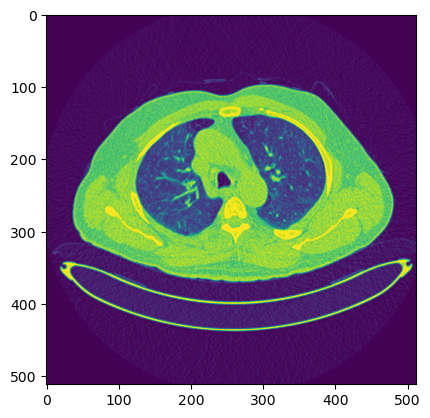

Malignant cases


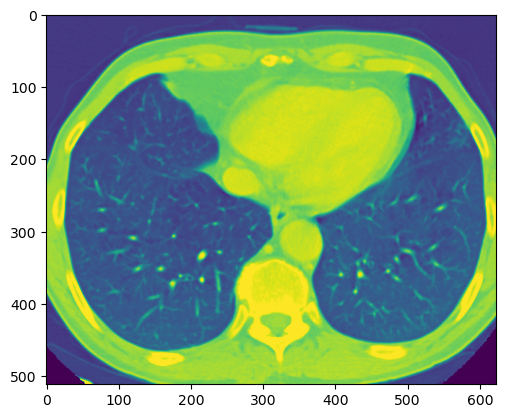

Normal cases


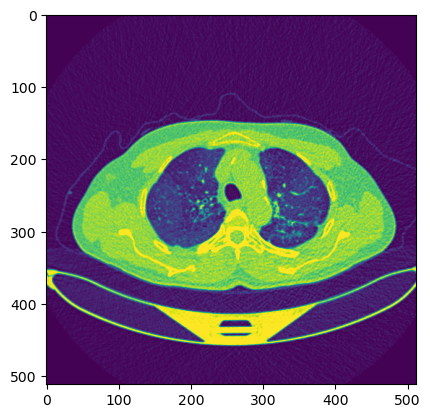

In [8]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

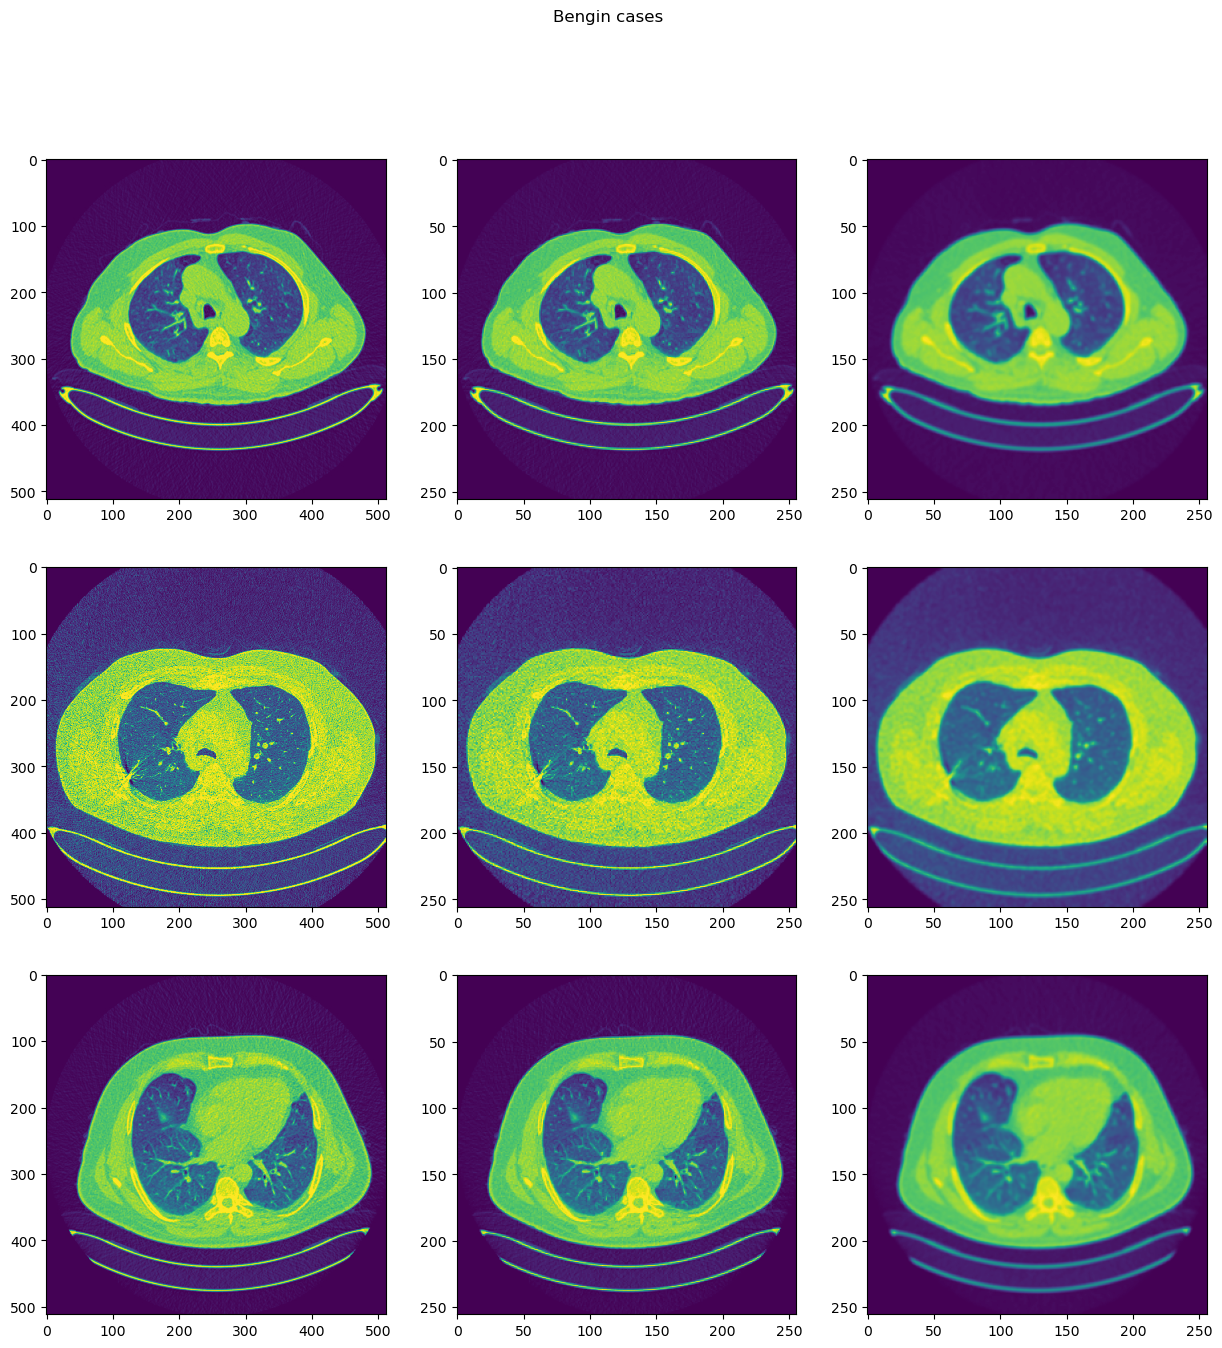

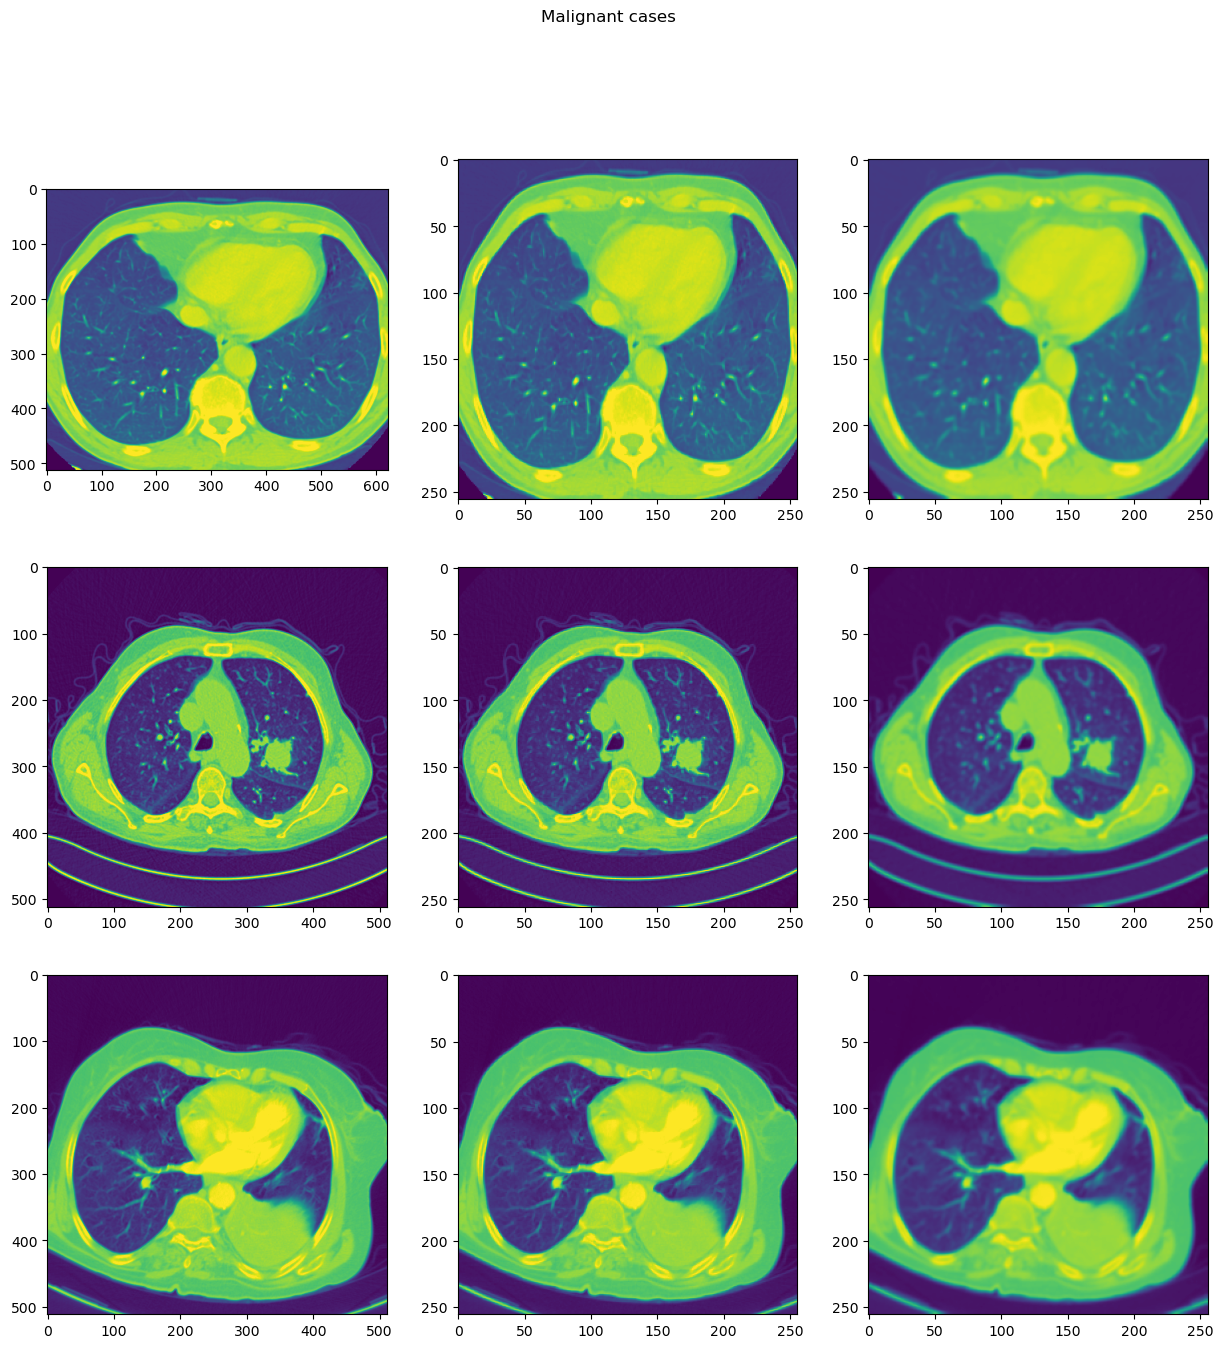

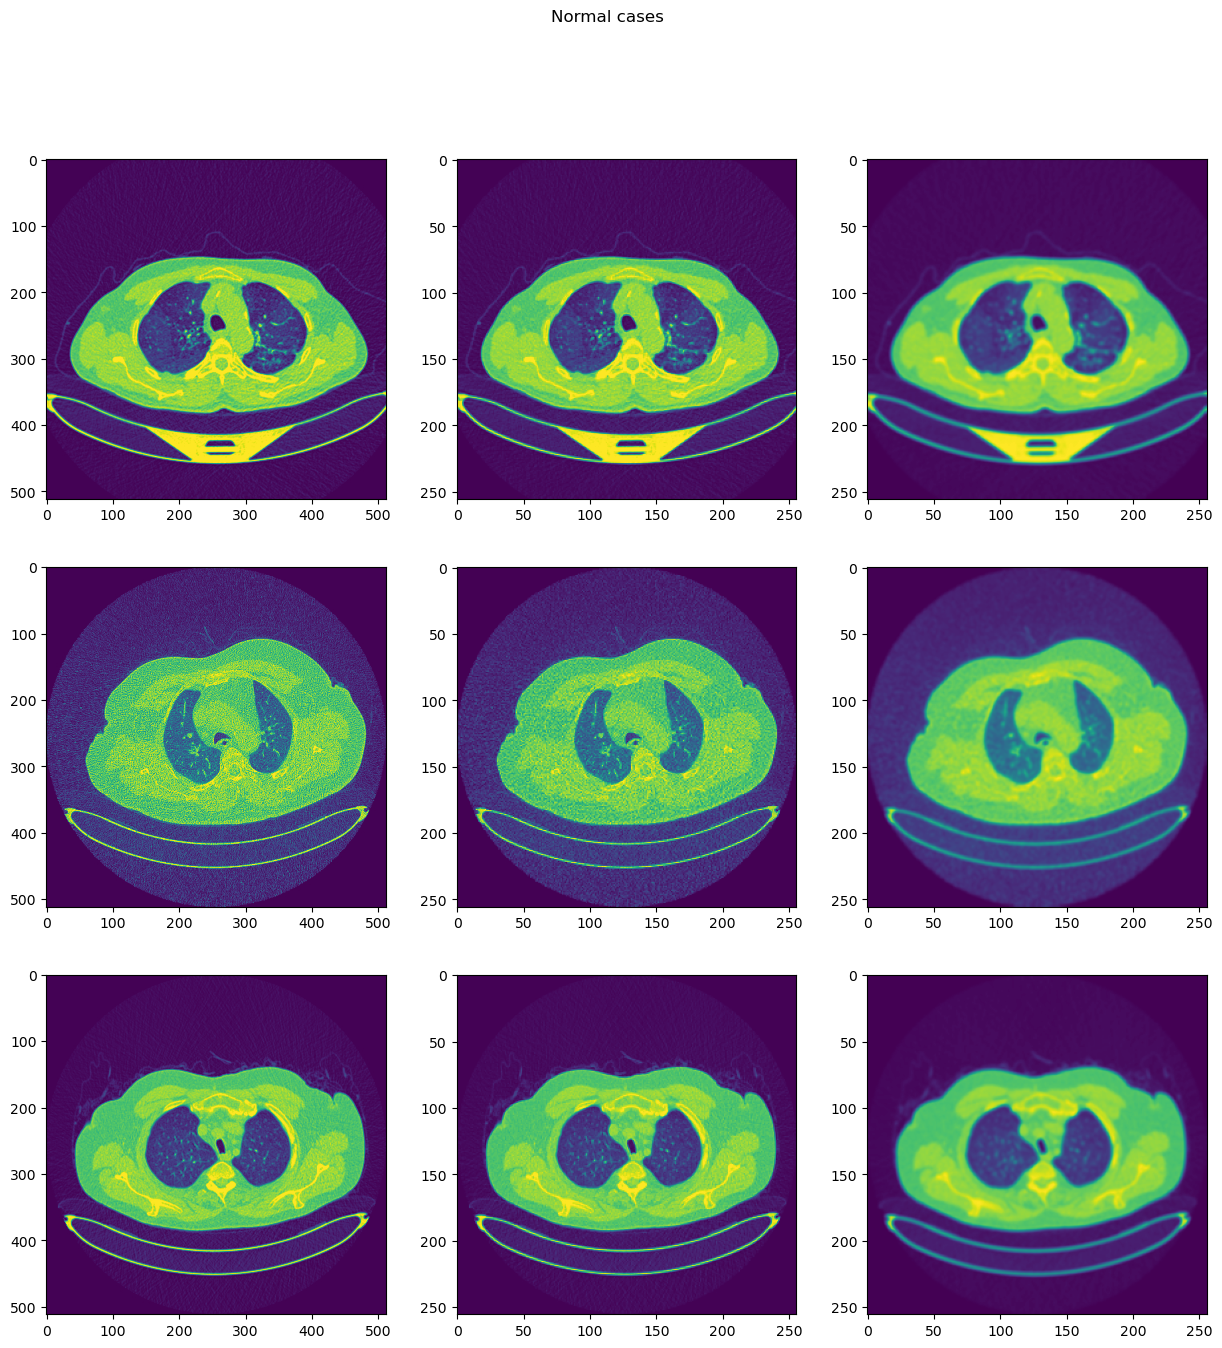

In [9]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)
    
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        
        img0 = cv2.resize(img, (img_size, img_size))
        
        img1 = cv2.GaussianBlur(img0, (5, 5), 0)
        
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break
        
plt.show()

In [10]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])
        
random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)
    
print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)

print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

822 (822, 256, 256, 1)
275 (275, 256, 256, 1)


In [12]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 420, 2: 312, 0: 90}) Counter({1: 141, 2: 104, 0: 30})


In [13]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [14]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 420, 2: 312, 0: 90})
After SMOTE: Counter({2: 420, 1: 420, 0: 420})


In [15]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1260 (1260, 256, 256, 1)


In [16]:
X_train.shape

(822, 256, 256, 1)

In [17]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1260 (1260, 256, 256, 1)


In [18]:
model1 = Sequential()

model1.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(16))
model1.add(Dense(3, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      640       
                                                                 
 activation (Activation)     (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0

In [19]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
history = model1.fit(X_train_sampled, y_train_sampled, batch_size=8, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10


2022-11-10 22:23:15.575854: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


158/158 [==============================] - 77s 487ms/step - loss: 0.4877 - accuracy: 0.8286 - val_loss: 0.1845 - val_accuracy: 0.9636
Epoch 2/10
158/158 [==============================] - 60s 380ms/step - loss: 0.0585 - accuracy: 0.9881 - val_loss: 0.0868 - val_accuracy: 0.9782
Epoch 3/10
158/158 [==============================] - 62s 393ms/step - loss: 0.0197 - accuracy: 0.9968 - val_loss: 0.0690 - val_accuracy: 0.9818
Epoch 4/10
158/158 [==============================] - 62s 390ms/step - loss: 0.0270 - accuracy: 0.9937 - val_loss: 0.0555 - val_accuracy: 0.9782
Epoch 5/10
158/158 [==============================] - 63s 399ms/step - loss: 0.0220 - accuracy: 0.9944 - val_loss: 0.5849 - val_accuracy: 0.8255
Epoch 6/10
158/158 [==============================] - 64s 401ms/step - loss: 0.0395 - accuracy: 0.9897 - val_loss: 0.0701 - val_accuracy: 0.9818
Epoch 7/10
158/158 [==============================] - 61s 388ms/step - loss: 0.0056 - accuracy: 0.9984 - val_loss: 0.0859 - val_accuracy: 0.9

In [21]:
y_pred = model1.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 4s 459ms/step
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        30
           1       0.99      1.00      1.00       141
           2       0.98      0.98      0.98       104

    accuracy                           0.99       275
   macro avg       0.98      0.97      0.98       275
weighted avg       0.99      0.99      0.99       275

[[ 28   0   2]
 [  0 141   0]
 [  1   1 102]]


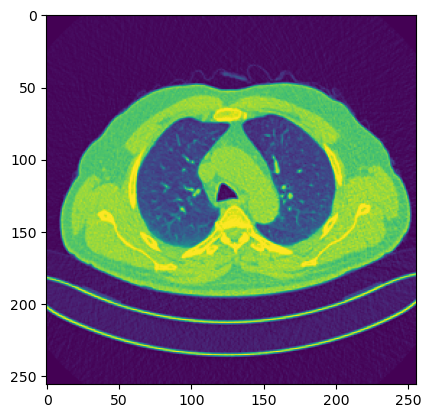

In [22]:
plt.imshow(X_train[1])

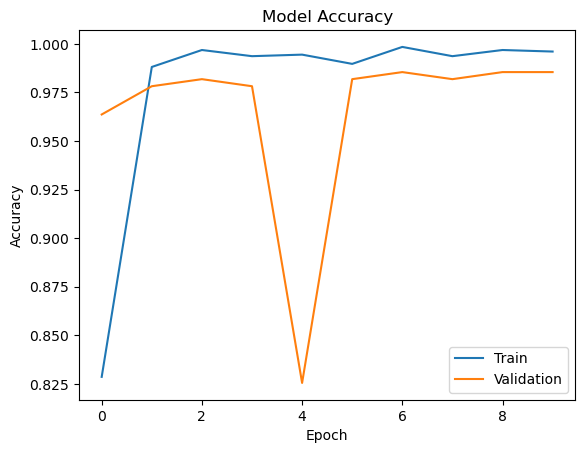

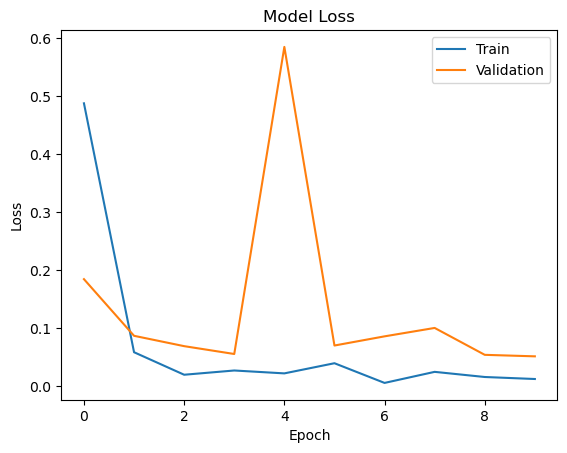

In [23]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [24]:
model1.save("LungCancerDetection.h5")

(256, 256)


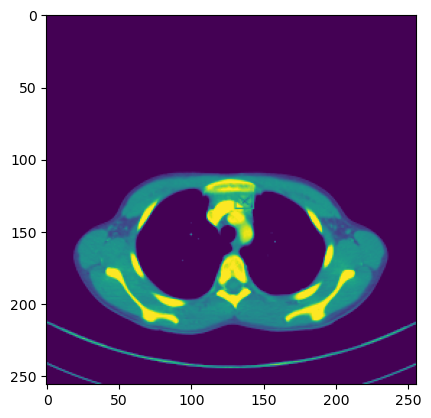

In [4]:
print(X_valid[1].shape)


# plt.imshow(resize)




NameError: name 'X_valid' is not defined

(256, 256)
1/1 [==============================] - 0s 54ms/step
1
Image belong to Malignant Cases


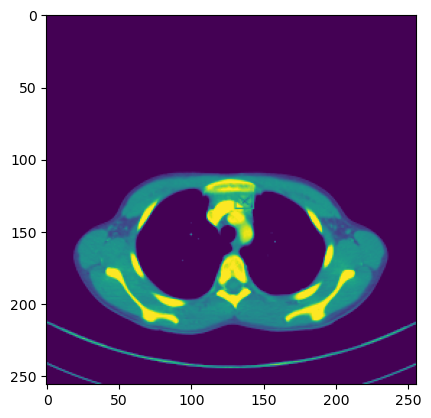

In [7]:
new_model = tf.keras.models.load_model('/Users/vansh/Desktop/Project 3/LungCancerDetection.h5')

path = r'/Users/vansh/Desktop/Project 3/Data/Test cases/000021_01_01_016.png'


a  = cv2.imread(path,cv2.IMREAD_GRAYSCALE)

b = cv2.resize(a, (256,256))
print(b.shape)
plt.imshow(b)


y_pred = new_model.predict(np.expand_dims(b,0))
index  = np.argmax(y_pred)
print(index)

if index == 0:
    print("Image belong to Bengin Cases")
elif index == 1:
    print("Image belong to Malignant Cases")
else:
    print("It looks normal")

In [98]:
new_model.predict(X-X_train[1])

35/35 [==============================] - 18s 508ms/step


array([[4.7350853e-15, 9.9194497e-01, 8.0550546e-03],
       [0.0000000e+00, 1.0000000e+00, 1.0908329e-21],
       [4.2974198e-16, 1.2660437e-02, 9.8733962e-01],
       ...,
       [3.4022161e-01, 1.0035557e-12, 6.5977836e-01],
       [2.6170954e-18, 1.0000000e+00, 3.3365225e-08],
       [1.6991467e-27, 1.0000000e+00, 2.1445362e-13]], dtype=float32)

In [ ]:

# Class weights give all the classes equal importance on gradient updates, on average, regardless of how many samples
# we have from each class in the training data. This prevents models from predicting the more frequent class
# more often just because it's more common.
